In [1]:
pip install simpy

  Obtaining dependency information for simpy from https://files.pythonhosted.org/packages/48/72/920ed1224c94a8a5a69e6c1275ac7fe4eb911ba8feffddf469f1629d47f3/simpy-4.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


e:\Anaconda\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
e:\Anaconda\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


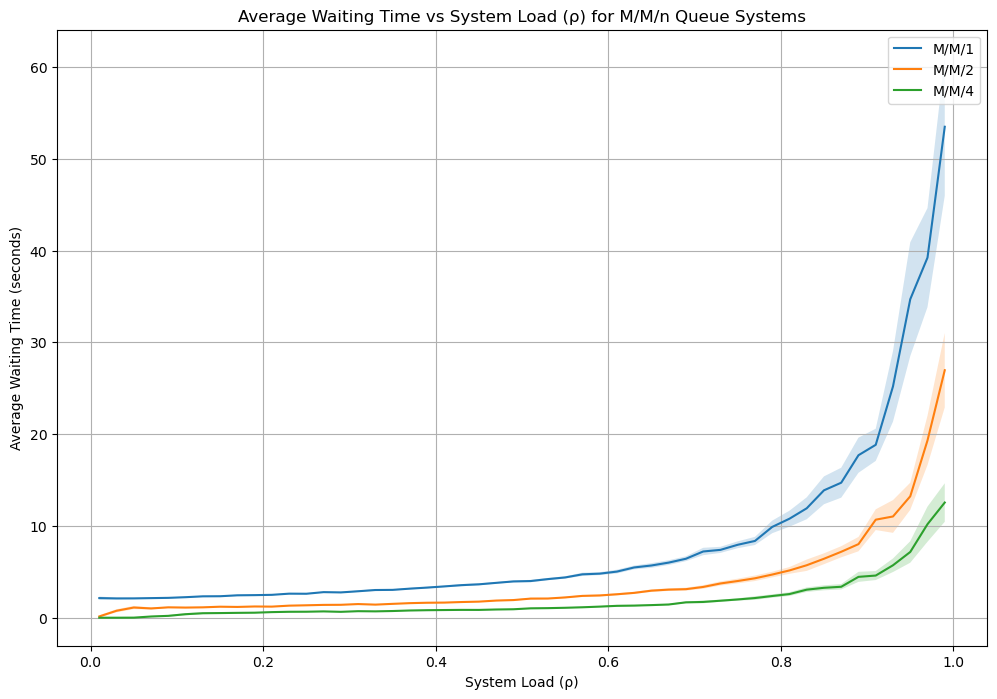

In [9]:
import numpy as np
import queue
import scipy.stats as stats
import matplotlib.pyplot as plt

def exponential(rate):
    """Generate exponential random variable."""
    return -np.log(1.0 - np.random.random()) / rate

class Server:
    def __init__(self, mu):
        self.mu = mu
        self.busy = False
        self.end_time = 0

    def start_service(self, current_time):
        self.busy = True
        self.end_time = current_time + exponential(self.mu)

    def end_service(self):
        self.busy = False

class MMnQueue:
    def __init__(self, n, lambda_rate, mu):
        self.servers = [Server(mu) for _ in range(n)]
        self.queue = queue.Queue()
        self.lambda_rate = lambda_rate
        self.mu = mu
        self.wait_times = []
        self.current_time = 0

    def run_simulation(self, max_events):
        num_events = 0

        while num_events < max_events:
            arrival_time = self.current_time + exponential(self.lambda_rate)

            next_end = min([s.end_time for s in self.servers if s.busy], default=float('inf'))
            
            if next_end <= arrival_time:
                self.current_time = next_end
                for server in self.servers:
                    if server.busy and server.end_time <= self.current_time:
                        server.end_service()
                        if not self.queue.empty():
                            waiting_customer = self.queue.get()
                            self.wait_times.append(self.current_time - waiting_customer)
                            server.start_service(self.current_time)
            else:
                self.current_time = arrival_time
                free_server = next((s for s in self.servers if not s.busy), None)
                if free_server is not None:
                    free_server.start_service(self.current_time)
                else:
                    self.queue.put(self.current_time)
            
            num_events += 1

        return np.mean(self.wait_times) if self.wait_times else 0

def run_monte_carlo_simulation(n_servers, lambda_rate, mu, max_events, num_runs):
    avg_waiting_times = []
    for _ in range(num_runs):
        queue_system = MMnQueue(n_servers, lambda_rate, mu)
        avg_waiting_time = queue_system.run_simulation(max_events)
        avg_waiting_times.append(avg_waiting_time)

    mean_waiting_time = np.mean(avg_waiting_times)
    std_dev = np.std(avg_waiting_times)
    std_error = std_dev / np.sqrt(num_runs)
    confidence_interval = stats.norm.interval(0.95, loc=mean_waiting_time, scale=std_error)

    return mean_waiting_time, confidence_interval

def simulate_different_rho(n_servers, mu, rho_values, max_events, num_runs):
    results = {n: {'avg_times': [], 'conf_intervals': []} for n in n_servers}
    for rho in rho_values:
        for n in n_servers:
            lambda_rate = rho * n * mu  # Calculate lambda based on rho and mu for each n
            mean_waiting_time, conf_interval = run_monte_carlo_simulation(n, lambda_rate, mu, max_events, num_runs)
            results[n]['avg_times'].append(mean_waiting_time)
            results[n]['conf_intervals'].append(conf_interval)
    return results

# Parameters
mu = 0.5          # Service rate
n_servers = [1, 2, 4]  # Number of servers in different scenarios
rho_values = np.linspace(0.01, 0.99, 50)  # Range of rho values
max_events = 3000   # Number of events to simulate per run
num_runs = 50     # Number of simulation runs for Monte Carlo

# Run simulation
simulation_results = simulate_different_rho(n_servers, mu, rho_values, max_events, num_runs)

# Plotting with linear y-axis
plt.figure(figsize=(12, 8))

for n in n_servers:
    avg_times = simulation_results[n]['avg_times']
    conf_intervals = simulation_results[n]['conf_intervals']
    lower_bounds = [avg - (upper-lower)/2 for avg, (lower, upper) in zip(avg_times, conf_intervals)]
    upper_bounds = [avg + (upper-lower)/2 for avg, (lower, upper) in zip(avg_times, conf_intervals)]

    plt.plot(rho_values, avg_times, label=f'M/M/{n}')
    plt.fill_between(rho_values, lower_bounds, upper_bounds, alpha=0.2)

plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time (seconds)')
plt.title('Average Waiting Time vs System Load (ρ) for M/M/n Queue Systems')
plt.legend()
plt.grid(True)
plt.show()

From the graph, we can make several observations regarding the number of measurements (simulations) required to achieve reliable results as it relates to ρ:

Low ρ (Underloaded System): When the system load ρ is low (far from 1), the confidence intervals are narrow for all queue systems. This indicates that the system is not congested, and relatively fewer measurements are needed to achieve a high confidence level because the system is inherently more stable and less variable.

Increasing ρ (Approaching Capacity): As ρ increases and approaches 1, the confidence intervals become wider, especially for the M/M/1 queue system. This suggests that the system is becoming more congested and variable, leading to higher fluctuations in waiting times. As a result, more measurements are required to attain a high confidence level because of the increased variance in the system's performance.

High ρ (Near or at Capacity): When ρ is very close to 1, the queue systems show a sharp increase in average waiting time and the confidence intervals become very wide, particularly for the M/M/1 system. This indicates a highly congested system where waiting times can vary widely from one simulation to another. To achieve a confidence level greater than 95%, a significantly larger number of measurements is necessary to accurately capture the variability and estimate the average waiting time.

Effect of Multiple Servers (n > 1): The M/M/2 and M/M/4 systems have smaller increases in waiting times and narrower confidence intervals compared to the M/M/1 system as ρ approaches 1. This demonstrates that systems with more servers can handle higher loads more effectively and with less variability, thus requiring fewer measurements to achieve the same confidence level compared to a single-server system.

In conclusion, the number of measurements required to achieve a desired confidence level depends on the system load ρ. More measurements are needed as the system load approaches its capacity (ρ approaches 1) due to increased variability in the system's performance. Additionally, queue systems with more servers are more stable under higher loads, reducing the number of measurements required to attain a high confidence level.

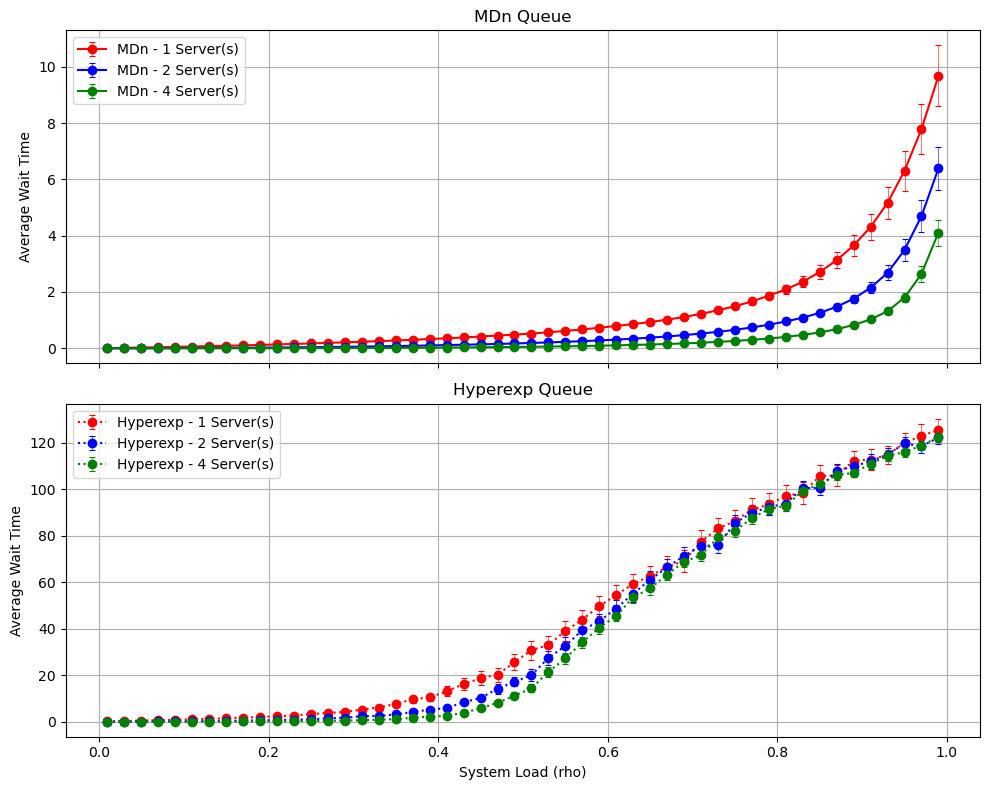

In [15]:
import simpy
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def multi_customer(env, name, counter, service_type, mu):
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)

        if service_type == "MDn":
            service_time = 1 / mu
        elif service_type == "Hyperexp":
            if random.random() < 0.75:
                service_time = random.expovariate(1/1.0)
            else:
                service_time = random.expovariate(1/5.0)

        yield env.timeout(service_time)

def multi_setup(env, n, service_type, lambda_, mu):
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(lambda_))
        env.process(multi_customer(env, f'multi_customer{env.now}', counter, service_type, mu))

mu = 1.0  # Service rate
servers = [1, 2, 4]
service_types = ["MDn", "Hyperexp"]
rhos = np.linspace(0.01, 0.99, 50)  # System load (rho)

average_wait_times = {
    service_type: {
        n: {
            rho: {"average": 0, "conf_int": 0}
            for rho in rhos
        } for n in servers
    } for service_type in service_types
}

sim_time = 500
num_runs = 100

for service_type in service_types:
    for n in servers:
        for rho in rhos:
            # Calculate lambda for this rho and n
            lambda_ = rho * n * mu
            all_run_avg_waits = []

            for run in range(num_runs):
                random.seed(0 + run)
                wait_times = []
                env = simpy.Environment()
                env.process(multi_setup(env, n, service_type, lambda_, mu))
                env.run(until=sim_time)

                average_wait = stats.tmean(wait_times) if wait_times else 0
                all_run_avg_waits.append(average_wait)

            final_avg_wait = stats.tmean(all_run_avg_waits)
            final_std_dev = stats.tstd(all_run_avg_waits)
            z_score = stats.norm.ppf(0.975)
            margin_of_error = z_score * (final_std_dev / (num_runs ** 0.5))

            average_wait_times[service_type][n][rho] = {"average": final_avg_wait, "conf_int": margin_of_error}

color_map = {1: 'red', 2: 'blue', 4: 'green'}
line_styles = {'MDn': 'o-', 'Hyperexp': 'o:'}

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot data for 'MDn' on the first subplot
for n in servers:
    means = [average_wait_times['MDn'][n][rho]["average"] for rho in rhos]
    conf_ints = [average_wait_times['MDn'][n][rho]["conf_int"] for rho in rhos]
    axs[0].errorbar(rhos, means, yerr=conf_ints,
                    label=f'MDn - {n} Server(s)',
                    fmt=line_styles['MDn'],
                    color=color_map[n],
                    ecolor=color_map[n],
                    elinewidth=0.4,
                    capsize=2,
                    capthick=0.8)

axs[0].set_title('MDn Queue')
axs[0].set_ylabel('Average Wait Time')
axs[0].legend()
axs[0].grid(True)

# Plot data for 'Hyperexp' on the second subplot
for n in servers:
    means = [average_wait_times['Hyperexp'][n][rho]["average"] for rho in rhos]
    conf_ints = [average_wait_times['Hyperexp'][n][rho]["conf_int"] for rho in rhos]
    axs[1].errorbar(rhos, means, yerr=conf_ints,
                    label=f'Hyperexp - {n} Server(s)',
                    fmt=line_styles['Hyperexp'],
                    color=color_map[n],
                    ecolor=color_map[n],
                    elinewidth=0.4,
                    capsize=2,
                    capthick=0.8)

axs[1].set_title('Hyperexp Queue')
axs[1].set_xlabel('System Load (rho)')
axs[1].set_ylabel('Average Wait Time')
axs[1].legend()
axs[1].grid(True)

# Adjust the layout so the subplots fit into the figure area.
plt.tight_layout()
plt.show()